# Notebook 1 - Simple Analyzer

This notebook takes CMS OpenData nanoAOD files, applies some selection and make few simple plots. 

Expected output: Histograms with the event selection.


Physics objects of interest: muons and jets. 

For more information: https://github.com/HEP-EPN/FourTopsCMSOpenData/wiki. 

To understand more about coffea (extremely useful): https://coffeateam.github.io/coffea/index.html. 

Let's first load the libraries:

In [1]:
import asyncio
import logging
import os
import time

import vector; vector.register_awkward() 
import awkward as ak
from coffea import processor
from coffea.nanoevents import transforms
from coffea.nanoevents.methods import base, vector
from coffea.nanoevents import NanoAODSchema
import hist
import json
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import uproot

import pandas as pd

For future use, let's define some global configuration

In [3]:
#ifile = uproot.open("root://eosuser.cern.ch//eos/user/a/algomez/tmpFiles/opendata_files/SingleElectron/cmsopendata2015_Run2015D_SingleElectron_MINIAOD_08Jun2016-v1_21.root")
#ifile["Events"].keys()

#events = NanoEventsFactory.from_root(
#    "https://xrootd-local.unl.edu:1094//store/user/AGC/nanoAOD/TT_TuneCUETP8M1_13TeV-powheg-pythia8/cmsopendata2015_ttbar_19980_PU25nsData2015v1_76X_mcRun2_asymptotic_v12_ext3-v1_00000_0000.root",
#    schemaclass=NanoAODSchema.v6,
#    metadata={"dataset": "TT"},
#).events()

In [2]:
DATA = "SingleMuon"  

# input files per process, set to e.g. 10 (smaller number = faster)
N_FILES_MAX_PER_SAMPLE = 10

### BENCHMARKING-SPECIFIC SETTINGS

# chunk size to use
CHUNKSIZE = 500_000

# metadata to propagate through to metrics
CORES_PER_WORKER = 2  # does not do anything, only used for metric gathering (set to 2 for distributed coffea-casa)

# scaling for local setups with FuturesExecutor
NUM_CORES = 4

NanoAOD datasets are stored in `data/ntuples_nanoaod.json` folder. This json file contains information about the number of events, process and systematic. The following function reads the json file and returns a dictionary with the process to run.

In [3]:
def construct_fileset(n_files_max_per_sample,
                      dataset="SingleMuon",
                      onlyNominal=False,
                      ntuples_json="ntuples_nanoaod.json"):
    # using https://atlas-groupdata.web.cern.ch/atlas-groupdata/dev/AnalysisTop/TopDataPreparation/XSection-MC15-13TeV.data
    # for reference
    # x-secs are in pb
    xsec_info = {
        "ttbar": 831., ###396.87 + 332.97, # nonallhad + allhad, keep same x-sec for all
       # "single_top_s_chan": 2.0268 + 1.2676,
       # "single_top_t_chan": (36.993 + 22.175)/0.252,  # scale from lepton filter to inclusive
       # "single_top_tW": 35.6 + 35.6, #37.936 + 37.906,
       # "wjets": 61526, ##61457 * 0.252,  # e/mu+nu final states
        "tttt" : 0.009, 
        "data": None
    }

    # list of files
    with open(ntuples_json) as f:
        file_info = json.load(f)
    
    # process into "fileset" summarizing all info
    fileset = {}
    for process in file_info.keys():
        if process == "data":
            file_list = file_info[process][dataset]["files"]
            if n_files_max_per_sample != -1:
                #file_list = file_list[:int(n_files_max_per_sample/10)]
                file_list = file_list[:]  # use all data

            file_paths = [f["path"] for f in file_list]
            metadata = {"process": "data", "xsec": 1}
            fileset.update({"data": {"files": file_paths, "metadata": metadata}})
            

        for variation in file_info[process].keys():
            if onlyNominal & ~variation.startswith("nominal"): continue
            #print(variation)
            file_list = file_info[process][variation]["files"]
            if n_files_max_per_sample != -1:
                file_list = file_list[:n_files_max_per_sample]  # use partial set of samples, first 10 files

            file_paths = [f["path"] for f in file_list]
            nevts_total = sum([f["nevts"] for f in file_list])
            metadata = {"process": process, "variation": variation, "nevts": nevts_total, "xsec": xsec_info[process]}
            fileset.update({f"{process}__{variation}": {"files": file_paths, "metadata": metadata}})
            

    return fileset


In [4]:
fileset = construct_fileset(N_FILES_MAX_PER_SAMPLE, dataset=DATA,
                            onlyNominal=True, ntuples_json='../Tesis/ntuples_nanoaod.json') 

#print(fileset["ttbar__nominal"]["metadata"]["nevts"])
print(fileset["tttt__nominal"]["metadata"]["process"])
#print(fileset["wjets__nominal"]["metadata"]["nevts"])
print(fileset["ttbar__nominal"]["metadata"]["process"])
#print(f"\nexample of information in fileset:\n{{\n  'files': [{fileset['ttbar__nominal']['files'][0]}, ...],")
#print(f"  'metadata': {fileset['ttbar__nominal']['metadata']}\n}}")
#print(f"\nexample of data information in fileset:\n{{\n  'files': [{fileset['data']['files'][0]}, ...],")

tttt
ttbar


In [12]:
data_files = fileset["data"]["files"]

# Loop over the files and count the number of events in each one
nevents = 0
for data_file in data_files:
    with uproot.open(data_file) as rootfile:
        # Get the number of events in the "Events" TTree
        tree = rootfile["Events"]
        #print(len(tree))
        nevents += len(tree)

print(f"Total number of events: {nevents}")

Total number of events: 32938


## Analyzer

Here is the main analyzer. Uses coffea/awkward to make the analysis.

Advice: to understand how the selection is working, print the different arrays before and after the selections are made.

In [5]:
class fourTopAnalysis(processor.ProcessorABC):
    def __init__(self, DATASET):
        
        self.DATASET = DATASET

        ### booking histograms
        ## define categories
        process_cat = hist.axis.StrCategory([], name="process", label="Process", growth=True)
        variation_cat  = hist.axis.StrCategory([], name="variation", label="Systematic variation", growth=True)
        
        ## define bins (axis)
        pt_axis = hist.axis.Regular( bins=500, start=0, stop=500, name="var")
        eta_axis = hist.axis.Regular( bins=40, start=-5, stop=5, name="var")
        num_axis = hist.axis.Regular( bins=20, start=0, stop=20, name="var")
        #Htb
        htb_axis=hist.axis.Regular( bins=100, start=0, stop=1000, name="var")
        #Htratio
        htrat_axis=hist.axis.Regular(bins=500,start=0, stop=1, name="var")
        #3rd-highest CSV
        csv_axis=hist.axis.Regular(bins=100,start=0, stop=1, name="var")
        
        
        ## define a dictionary of histograms
        self.hist_muon_dict = {
            'muon_pt'  : (hist.Hist(pt_axis, process_cat, variation_cat, storage=hist.storage.Weight())),
            'muon_eta' : (hist.Hist(eta_axis, process_cat, variation_cat, storage=hist.storage.Weight())),
            'nmuons'   : (hist.Hist(num_axis, process_cat, variation_cat, storage=hist.storage.Weight())),
            'jets_pt'  : (hist.Hist(pt_axis, process_cat, variation_cat, storage=hist.storage.Weight())),
            'jets_eta' : (hist.Hist(eta_axis, process_cat, variation_cat, storage=hist.storage.Weight())),
            'njets'    : (hist.Hist(num_axis, process_cat, variation_cat, storage=hist.storage.Weight())), 
            'nbjets'   : (hist.Hist(num_axis, process_cat, variation_cat, storage=hist.storage.Weight())),
            'htb'      : (hist.Hist(htb_axis, process_cat, variation_cat, storage=hist.storage.Weight())), #variable for bdt
            'htrat'    : (hist.Hist(htrat_axis, process_cat, variation_cat, storage=hist.storage.Weight())), #variable for bdt
            'third_highest_csv': (hist.Hist(csv_axis, process_cat, variation_cat, storage=hist.storage.Weight())) #variable for bdt

        }
        
        sumw_dict = {'sumw': processor.defaultdict_accumulator(float)
        }
        
        
        ### define vectors for scatter plot
        self.njets_signal_data = []
        self.njets_background_data = []
        self.nbjets_signal_data = []
        self.nbjets_background_data = []
        self.htb_signal_data = []
        self.htb_background_data = []
        self.htrat_signal_data = []
        self.htrat_background_data = []
        
        self.njets_values=[]
        self.nbjets_values=[]
        self.htb_values=[]
        self.htrat_values=[]
        
    

    def process(self, events):

        hists = self.hist_muon_dict.copy()

        process = events.metadata["process"]  # "ttbar" etc.

    
        if process != "data":
            # normalization for MC
            x_sec = events.metadata["xsec"]
            nevts_total = events.metadata["nevts"]
            lumi = 2256.38 # /pb integrated luminosity
            xsec_weight = x_sec * lumi / nevts_total #L*cross-section/N
        else:
            xsec_weight = 1

        events["pt_nominal"] = 1.0

        ### OBJECT SELECTION
        
        # Object selection: Muon (Tight - muon id definition in nanoAOD does not work, have to define manual)
        
        muon_is_global= events.Muon.isGlobal == True
        muon_is_tracker= events.Muon.isTracker == True
        
        loose_muon_selection= (events.Muon.pt > 10) & (abs(events.Muon.eta)<2.5) & (events.Muon.pfRelIso04_all < 0.25) & (muon_is_global | muon_is_tracker)
        selected_muon_selection = (events.Muon.pt > 26) & (abs(events.Muon.eta)<2.1) & (events.Muon.nTrackerLayers > 5) & (events.Muon.nStations > 0) & (abs(events.Muon.dxy) < 0.2) & (abs(events.Muon.dz) < 0.5) & (events.Muon.pfRelIso04_all < .15) & (muon_is_global & muon_is_tracker)
                # [[muon 1], [muon 1, muon 2],..]
                
        selected_muons=events.Muon[(loose_muon_selection & selected_muon_selection)]
        selected_muon= ak.count(selected_muons.pt, axis=1)==1 
        
        veto_muons=events.Muon[(loose_muon_selection & ~selected_muon_selection)] #  veto additional lose muon
        veto_muon= ak.count(veto_muons.pt, axis=1)== 0
        
        #Object selection: Jets
        selected_leptons = selected_muons 
        jet_selection = (events.Jet.pt * events["pt_nominal"] > 30) & (abs(events.Jet.eta) < 2.5) & (events.Jet.jetId > 1)
        selected_jets = events.Jet[jet_selection]
        nearest_lepton = selected_jets.nearest(selected_leptons, threshold=.4)
        selected_jets = selected_jets[ ~ak.is_none(nearest_lepton) ]
        
        ## the results of these 2 lines should be equivalent to the 2 lines above
        #lepton_mask = ak.any(selected_jets.metric_table(selected_lepton, metric=lambda j, e: ak.local_index(j, axis=1) == e.jetIdx,), axis=2)
        #selected_jets = selected_jets[~lepton_mask]
        
        selected_bjets = events.Jet[jet_selection & ~ak.is_none(nearest_lepton) & (events.Jet.btagCSVV2 >=0.8)]
        selected_jets_nobjets = events.Jet[jet_selection & ~ak.is_none(nearest_lepton) & ~(events.Jet.btagCSVV2 >=0.8)]  ### this we might use it later
        
       ################
        #### Event Selection
        ################
        
        if self.DATASET.endswith("Muon"):
            # trigger
            event_filters = ( events.HLT.IsoMu18 == 1 )  #trigger selection (1 value per event)
            selected_lepton = selected_muon
            veto_lepton = veto_muon

        event_filters = event_filters & ( selected_lepton & veto_lepton )
        # at least four jets
        event_filters = event_filters & (ak.count(selected_jets.pt, axis=1) >= 4)
        # at least one b-tagged jet ("tag" means score above threshold)
        event_filters = event_filters & (ak.sum(selected_bjets) >= 1)
        #print(event_filters)
        
        # apply event filters
        selected_events = events[event_filters]
        selected_muons = selected_muons[event_filters]
        selected_jets = selected_jets[event_filters]
        selected_bjets = selected_bjets[event_filters]
        
        ##### VARIABLES FOR BDT ####
        
        
        #### Calculate HTb
        htb = ak.sum(selected_bjets.pt, axis=1)
    
        
        #### Calculate H_t^ratio
        selected_jets_sorted = ak.sort(selected_jets.pt, axis=1, ascending=False)
        
        four_leading_jets=selected_jets_sorted[:, :4]
        ht_leading_jets=ak.sum(four_leading_jets,axis=1)
        
        other_jets=selected_jets_sorted[:, 4:]
        ht_other_jets = ak.sum(other_jets,axis=1)
        
        htrat = ht_other_jets/ht_leading_jets
        
        #### Calculate Third-highest CSV
        
        #Sort jets by CSV values 
        sorted_jets= ak.argsort(selected_jets.btagCSVV2, axis=1)
        
        #Extract the third-highest CSV value
        third_highest_csv = sorted_jets[:, 2]
        
        
        for ivar in [ "pt", "eta" ]:
            hists[f'muon_{ivar}'].fill(
                        var=ak.flatten(getattr(selected_muons, ivar)), process=process, variation="nominal", weight=xsec_weight)
            hists[f'jets_{ivar}'].fill(
                        var=ak.flatten(getattr(selected_jets, ivar)), process=process, variation="nominal", weight=xsec_weight)
            hists['nmuons'].fill(var=ak.count(selected_muons.pt, axis=1), process=process, variation="nominal", weight=xsec_weight)
            hists['njets'].fill(var=ak.count(selected_jets.pt, axis=1), process=process, variation="nominal", weight=xsec_weight)
            hists['nbjets'].fill(var=ak.count(selected_bjets.pt, axis=1), process=process,variation="nominal", weight=xsec_weight)
            hists['htb'].fill(var=htb, process=process, variation="nominal", weight=xsec_weight)
            hists['htrat'].fill(var=htrat, process=process, variation="nominal", weight=xsec_weight)
            hists['third_highest_csv'].fill(var=third_highest_csv, process=process, variation="nominal", weight=xsec_weight)
            
            njets_values = ak.count(selected_jets.pt, axis=1)
            nbjets_values=ak.count(selected_bjets.pt, axis=1)
            htrat_values=htrat
            htb_values=htb
            
            if process == "tttt":
                self.njets_signal_data.extend(njets_values)
                self.nbjets_signal_data.extend(nbjets_values)
                self.htb_signal_data.extend(htb)
                self.htrat_signal_data.extend(htrat)
                
            elif process == "ttbar":
                self.njets_background_data.extend(njets_values)
                self.nbjets_background_data.extend(nbjets_values)
                self.htb_background_data.extend(htb)
                self.htrat_background_data.extend(htrat)
     
            output = {"nevents": {events.metadata["dataset"]: len(events)}, "hists" : hists, "njets_signal_data": self.njets_signal_data,
        "njets_background_data": self.njets_background_data,
        "nbjets_signal_data": self.nbjets_signal_data,
        "nbjets_background_data": self.nbjets_background_data, 
        "htb_signal_data": self.htb_signal_data,
        "htb_background_data": self.htb_background_data,
        "htrat_signal_data":self.htrat_signal_data,
        "htrat_background_data":self.htrat_background_data}
        
            return output

    def postprocess(self, accumulator):
        
             
        return accumulator

Let's make it run:

In [6]:
executor = processor.FuturesExecutor(workers=NUM_CORES)

run = processor.Runner(executor=executor, schema=NanoAODSchema, 
                       savemetrics=True, metadata_cache={}, chunksize=CHUNKSIZE)
t0 = time.monotonic()
all_histograms, metrics = run(fileset, "Events", processor_instance=fourTopAnalysis(DATASET=DATA))
exec_time = time.monotonic() - t0


Preprocessing:   0%|          | 0/56 [00:00<?, ?file/s]

Processing:   0%|          | 0/69 [00:00<?, ?chunk/s]

/cvmfs/sft.cern.ch/lcg/views/LCG_103swan/x86_64-centos7-gcc11-opt/lib/python3.9/site-packages/coffea/nanoevents/schemas/nanoaod.py:193: RuntimeWarning: Missing cross-reference index for FatJet_subJetIdx1 => SubJet
  warnings.warn(
/cvmfs/sft.cern.ch/lcg/views/LCG_103swan/x86_64-centos7-gcc11-opt/lib/python3.9/site-packages/coffea/nanoevents/schemas/nanoaod.py:193: RuntimeWarning: Missing cross-reference index for FatJet_subJetIdx2 => SubJet
  warnings.warn(
/cvmfs/sft.cern.ch/lcg/views/LCG_103swan/x86_64-centos7-gcc11-opt/lib/python3.9/site-packages/coffea/nanoevents/schemas/nanoaod.py:193: RuntimeWarning: Missing cross-reference index for FatJet_subJetIdx1 => SubJet
  warnings.warn(
/cvmfs/sft.cern.ch/lcg/views/LCG_103swan/x86_64-centos7-gcc11-opt/lib/python3.9/site-packages/coffea/nanoevents/schemas/nanoaod.py:193: RuntimeWarning: Missing cross-reference index for FatJet_subJetIdx2 => SubJet
  warnings.warn(
/cvmfs/sft.cern.ch/lcg/views/LCG_103swan/x86_64-centos7-gcc11-opt/lib/python

## BDT a-like process

We want to examine the distributions of the input variables for signal and background events. Look for regions of the input space where signal events tend to have different characteristics than background events. Based on this, define selection cuts for each input variable to separate signal from background.

We added the libraries we'll need.

In [7]:
import mplhep as hep
import numpy as np
import pandas as pd
import uproot
import matplotlib.pyplot as plt
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import auc, roc_curve
from sklearn.model_selection import KFold
from xgboost import XGBClassifier

Lets first do some plots of some variable1 vs variable2, to see where some cuts could be done.

In [8]:
njsig=all_histograms["njets_signal_data"]
njbkg=all_histograms["njets_background_data"]


Now let’s plot the variables in signal and background to see what they look like. (Density of data)

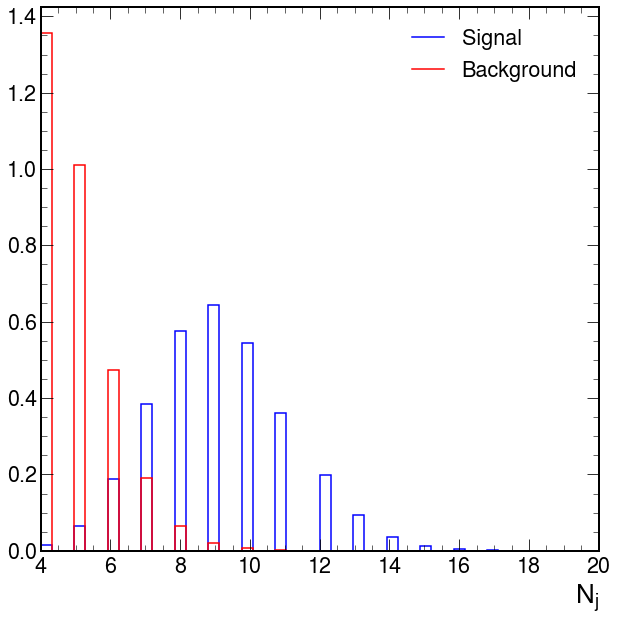

In [9]:
plt.style.use(hep.style.CMS)

njsig, bins = np.histogram(njsig, bins=50)
njbkg, bins = np.histogram(njbkg, bins=bins)  

hep.histplot(njsig, bins=bins, label='Signal', density=1, color='blue')
hep.histplot(njbkg, bins=bins, label='Background', density=1, color='red')
plt.xlabel('$N_j$')
plt.xlim(bins[0], bins[-1])
plt.legend(loc='best')

In [10]:
njsig = all_histograms["njets_signal_data"]
njbkg = all_histograms["njets_background_data"]

nbjsig = all_histograms["nbjets_signal_data"]
nbjbkg = all_histograms["nbjets_background_data"]

htbsig = all_histograms["htb_signal_data"]
htbbkg = all_histograms["htb_background_data"]

htratsig = all_histograms["htrat_signal_data"]
htratbkg = all_histograms["htrat_background_data"]

In [11]:
def plot_comparision(var1,var2,var1_sig, var2_sig, var1_bkg, var2_bkg):

    plt.scatter(var1_sig, var2_sig, color='blue', label='Signal', alpha=0.5)
    plt.scatter(var1_bkg, var2_bkg, color='red', label='Background',alpha=0.5)
    # Add labels and legend
    plt.xlabel(var1)
    plt.ylabel(var2)
    plt.legend(loc='best')
    plt.show()

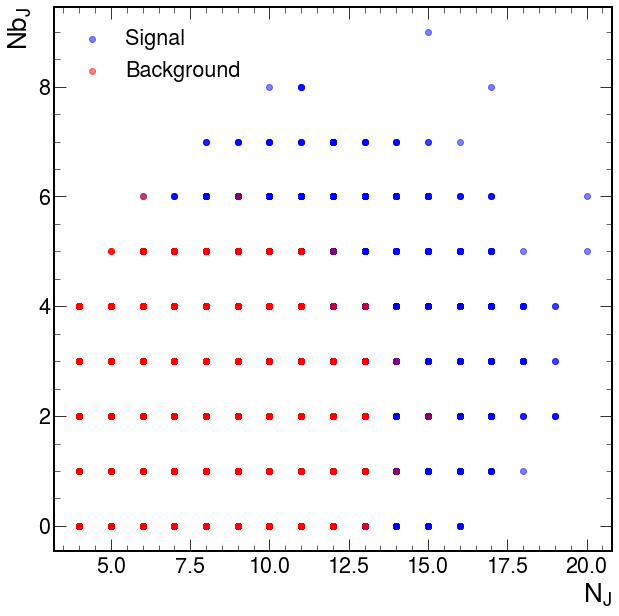

In [12]:
plot_comparision('$N_J$','$Nb_J$', njsig, nbjsig, njbkg, nbjbkg)

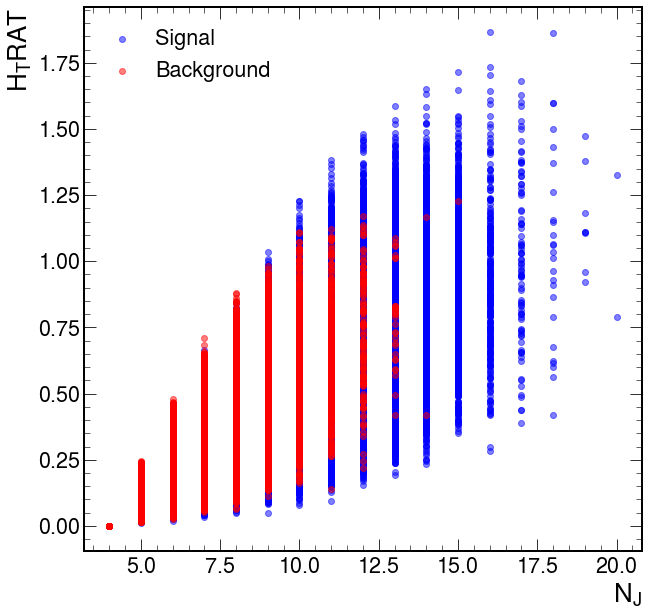

In [13]:
plot_comparision('$N_J$','$H_TRAT$', njsig, htratsig, njbkg, htratbkg)

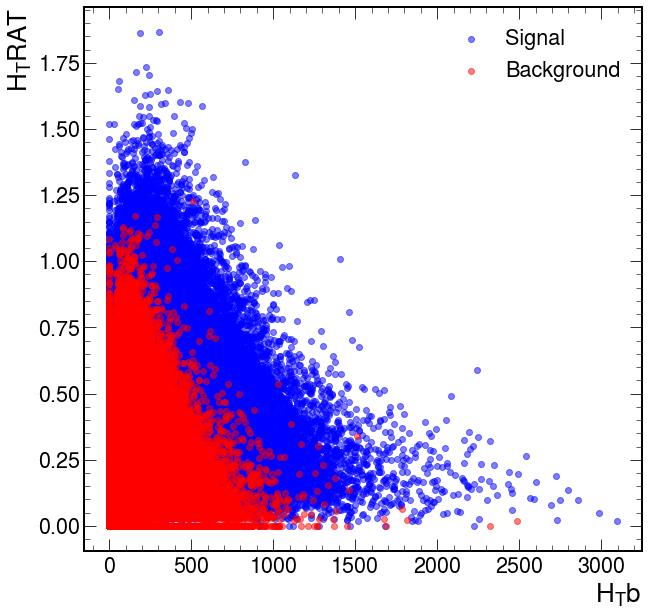

In [14]:
plot_comparision('$H_Tb$','$H_TRAT$', htbsig, htratsig, htbbkg, htratbkg)

Lets create some data frames that would be useful

In [15]:
signal_data = {'nj': njsig, 'nbj': nbjsig, 'htb':htbsig, 'htrat':htratsig}
background_data = {'nj': njbkg, 'nbj': nbjbkg, 'htb':htbbkg, 'htrat':htratbkg}

sig_df = pd.DataFrame(signal_data)
bkg_df = pd.DataFrame(background_data)

#sig_df.columns
bkg_df.columns
print(sig_df)
print(bkg_df)

        nj  nbj        htb     htrat
0       10    4  342.06250  0.844287
1       10    1   66.00000  0.530989
2       10    5  515.71875  0.923101
3       14    2  366.43750  0.695913
4        6    1   78.37500  0.314095
...     ..  ...        ...       ...
203727   6    2  284.62500  0.161142
203728   8    2  126.37500  0.434698
203729   8    1  147.75000  0.440840
203730  15    4  523.81250  0.972249
203731   6    3  215.87500  0.241493

[203732 rows x 4 columns]
        nj  nbj        htb     htrat
0        4    2  148.15625  0.000000
1        4    1   37.53125  0.000000
2        4    1  173.25000  0.000000
3        4    1   58.34375  0.000000
4        6    2  117.68750  0.344867
...     ..  ...        ...       ...
877491   4    2  105.93750  0.000000
877492   7    1   60.59375  0.457789
877493   5    1   59.59375  0.141211
877494   5    2  181.00000  0.120270
877495   4    1   74.18750  0.000000

[877496 rows x 4 columns]


In [16]:
nj=np.concatenate((njsig,njbkg))
nbj=np.concatenate((nbjsig,nbjbkg))
htb=np.concatenate((htbsig,htbbkg))
htrat=np.concatenate((htratsig,htratbkg))

training_columns=['nj','nbj','htb','htrat']

data = {'nj': nj, 'nbj': nbj, 'htb':htb, 'htrat':htrat}
data_df = pd.DataFrame(data)

%store training_columns
print(data_df)

Stored 'training_columns' (list)
         nj  nbj        htb     htrat
0        10    4  342.06250  0.844287
1        10    1   66.00000  0.530989
2        10    5  515.71875  0.923101
3        14    2  366.43750  0.695913
4         6    1   78.37500  0.314095
...      ..  ...        ...       ...
1081223   4    2  105.93750  0.000000
1081224   7    1   60.59375  0.457789
1081225   5    1   59.59375  0.141211
1081226   5    2  181.00000  0.120270
1081227   4    1   74.18750  0.000000

[1081228 rows x 4 columns]


In [17]:
# We then define the classifier we want to use
bdt = GradientBoostingClassifier()

In [18]:
bkg_df = bkg_df.copy()
bkg_df['catagory'] = 0  # Use 0 for background
sig_df['catagory'] = 1  # Use 1 for signal

print(bkg_df)

        nj  nbj        htb     htrat  catagory
0        4    2  148.15625  0.000000         0
1        4    1   37.53125  0.000000         0
2        4    1  173.25000  0.000000         0
3        4    1   58.34375  0.000000         0
4        6    2  117.68750  0.344867         0
...     ..  ...        ...       ...       ...
877491   4    2  105.93750  0.000000         0
877492   7    1   60.59375  0.457789         0
877493   5    1   59.59375  0.141211         0
877494   5    2  181.00000  0.120270         0
877495   4    1   74.18750  0.000000         0

[877496 rows x 5 columns]


In [19]:
# Now merge the data together
training_data = pd.concat([bkg_df, sig_df], copy=True, ignore_index=True)
# Store training_data for later
%store training_data

print(training_data)

Stored 'training_data' (DataFrame)
         nj  nbj        htb     htrat  catagory
0         4    2  148.15625  0.000000         0
1         4    1   37.53125  0.000000         0
2         4    1  173.25000  0.000000         0
3         4    1   58.34375  0.000000         0
4         6    2  117.68750  0.344867         0
...      ..  ...        ...       ...       ...
1081223   6    2  284.62500  0.161142         1
1081224   8    2  126.37500  0.434698         1
1081225   8    1  147.75000  0.440840         1
1081226  15    4  523.81250  0.972249         1
1081227   6    3  215.87500  0.241493         1

[1081228 rows x 5 columns]


In [20]:
bdt.fit(training_data[training_columns], training_data['catagory'])

GradientBoostingClassifier()

In [21]:
bdt.predict_proba(data_df[training_columns].head())

array([[0.01361471, 0.98638529],
       [0.1131076 , 0.8868924 ],
       [0.0099625 , 0.9900375 ],
       [0.00910046, 0.99089954],
       [0.96108631, 0.03891369]])

In [22]:
# We can now use slicing to select column 1 in the array from for all rows
probabilities = bdt.predict_proba(data_df[training_columns])[:,1]
probabilities

array([0.98638529, 0.8868924 , 0.9900375 , ..., 0.00877253, 0.01323472,
       0.00298282])

In [23]:
sig_df['BDT'] = bdt.predict_proba(sig_df[training_columns])[:,1]
bkg_df['BDT'] = bdt.predict_proba(bkg_df[training_columns])[:,1]
data_df['BDT'] = bdt.predict_proba(data_df[training_columns])[:,1]
training_data['BDT'] = bdt.predict_proba(training_data[training_columns])[:,1]

In [24]:
def plot_comparision(var, mc_df, bkg_df):
    # create histograms
    hsig, bins = np.histogram(mc_df[var], bins=60, density=1)
    hbkg, bins = np.histogram(bkg_df[var], bins=bins, density=1)

    hep.histplot((hsig, bins), label='Signal', color='blue' )
    hep.histplot(hbkg, bins=bins, label='Bkg', color='red')
    plt.xlabel(var)
    plt.xlim(bins[0], bins[-1])
    plt.legend(loc='best')

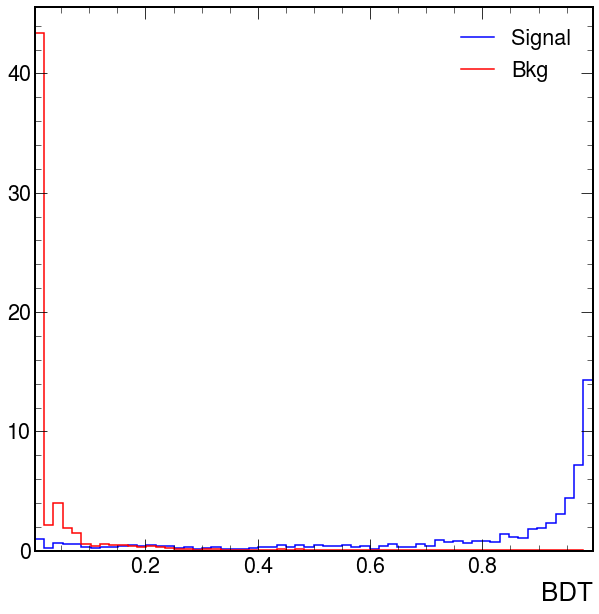

In [25]:
plot_comparision('BDT', sig_df, bkg_df)

In [26]:
y_score = bdt.predict_proba(training_data[training_columns])[:,1]
fpr, tpr, thresholds = roc_curve(training_data['catagory'], y_score)

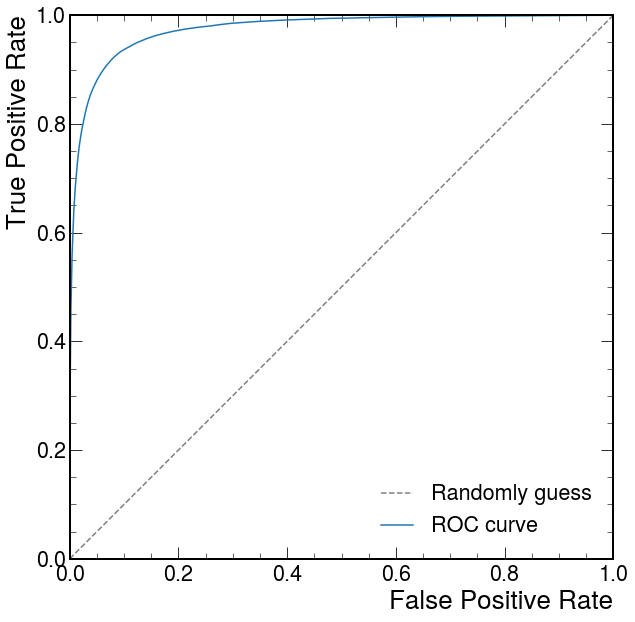

In [27]:
plt.plot([0, 1], [0, 1], color='grey', linestyle='--', label='Randomly guess')
plt.plot(fpr, tpr, label=f'ROC curve')
plt.xlim(0.0, 1.0)
plt.ylim(0.0, 1.0)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
# We can make the plot look nicer by forcing the grid to be square
plt.gca().set_aspect('equal', adjustable='box')

In [119]:
import pickle

with open("histograms.pkl", "wb") as f:
    pickle.dump(all_histograms["hists"], f, protocol=pickle.HIGHEST_PROTOCOL)

In [120]:
dataset_source = "/data" if fileset["ttbar__nominal"]["files"][0].startswith("/data") else "https://xrootd-local.unl.edu:1094" # TODO: xcache support
metrics.update({"walltime": exec_time, "num_workers": NUM_CORES, "dataset_source": dataset_source, 
                "n_files_max_per_sample": N_FILES_MAX_PER_SAMPLE, 
                "cores_per_worker": CORES_PER_WORKER, "chunksize": CHUNKSIZE})#

print(f"event rate per worker (full execution time divided by NUM_CORES={NUM_CORES}): {metrics['entries'] / NUM_CORES / exec_time / 1_000:.2f} kHz")
print(f"event rate per worker (pure processtime): {metrics['entries'] / metrics['processtime'] / 1_000:.2f} kHz")
print(f"amount of data read: {metrics['bytesread']/1000**2:.2f} MB")  # likely buggy: https://github.com/CoffeaTeam/coffea/issues/717


event rate per worker (full execution time divided by NUM_CORES=4): 2.71 kHz
event rate per worker (pure processtime): 3.08 kHz
amount of data read: 6709.93 MB
